### ML Using Python : Time Series Analysis & Forecasting - A Case Study 

Priyaranjan Mohanty

Time series analysis comprises methods for analyzing time series data in order to extract meaningful statistics and other characteristics of the data. Time series forecasting is the use of a model to predict future values based on previously observed values.
Time series are widely used for non-stationary data, like economic, weather, stock price, and retail sales in this post. 

In [39]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

import pandas as pd
import statsmodels.api as sm
import matplotlib


In [40]:
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

### The Data

We are using Superstore sales data 

In [81]:
Superstore_df = pd.read_excel("Sample - Superstore.xls")

In [42]:
Superstore_df.head(3)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2,0.0,6.8714


In [82]:
Superstore_df.shape

(9994, 21)

In [44]:
Superstore_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
Row ID           9994 non-null int64
Order ID         9994 non-null object
Order Date       9994 non-null datetime64[ns]
Ship Date        9994 non-null datetime64[ns]
Ship Mode        9994 non-null object
Customer ID      9994 non-null object
Customer Name    9994 non-null object
Segment          9994 non-null object
Country          9994 non-null object
City             9994 non-null object
State            9994 non-null object
Postal Code      9994 non-null int64
Region           9994 non-null object
Product ID       9994 non-null object
Category         9994 non-null object
Sub-Category     9994 non-null object
Product Name     9994 non-null object
Sales            9994 non-null float64
Quantity         9994 non-null int64
Discount         9994 non-null float64
Profit           9994 non-null float64
dtypes: datetime64[ns](2), float64(3), int64(3), object(13)
memory usage: 1.6+ 

In [83]:
Superstore_df.Category.unique()

array(['Furniture', 'Office Supplies', 'Technology'], dtype=object)

There are several categories in the Superstore sales data, we start from time series analysis and forecasting for furniture sales.

In [84]:
furniture_df = Superstore_df.loc[Superstore_df.Category == 'Furniture']

In [85]:
furniture_df.shape

(2121, 21)

In [86]:
furniture_df.head(2)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820


#### Find the range of Dates available for Furniture Data Frame 

In [87]:
furniture_df['Order Date'].min(), furniture_df['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

#### We have a good 4-year furniture sales data.

### Now , lets do Data Pre-Processing 

This step includes removing columns we do not need, check missing values, aggregate sales by date and so on.

In [88]:
cols_to_drop = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 
                'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 
                'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']

furniture_df.drop(cols_to_drop, 
                  axis=1, 
                  inplace=True)

In [89]:
furniture_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2121 entries, 0 to 9990
Data columns (total 2 columns):
Order Date    2121 non-null datetime64[ns]
Sales         2121 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 49.7 KB


In [90]:
furniture_df.head()

,Order Date,Sales
0,2016-11-08,261.9600
1,2016-11-08,731.9400
3,2015-10-11,957.5775
5,2014-06-09,48.8600
10,2014-06-09,1706.1840


#### Now lets sort the data by Date 

In [91]:
furniture_df = furniture_df.sort_values('Order Date')

In [92]:
furniture_df.shape

(2121, 2)

In [93]:
furniture_df.head()

,Order Date,Sales
7474,2014-01-06,2573.820
7660,2014-01-07,76.728
866,2014-01-10,51.940
716,2014-01-11,9.940
2978,2014-01-13,545.940


In [94]:
furniture_df.tail()

,Order Date,Sales
7636,2017-12-29,258.750
7632,2017-12-29,1207.840
5131,2017-12-29,101.120
7635,2017-12-29,300.980
906,2017-12-30,323.136


### Now lets check for Missing Values

In [95]:
furniture_df.isnull().sum()

Order Date    0
Sales         0
dtype: int64

### Reset the Indexes 

In [96]:
furniture_df = furniture_df.groupby('Order Date')['Sales'].sum().reset_index()

In [99]:
furniture_df.shape

(889, 2)

In [100]:
furniture_df.head()

,Order Date,Sales
0,2014-01-06,2573.820
1,2014-01-07,76.728
2,2014-01-10,51.940
3,2014-01-11,9.940
4,2014-01-13,879.939


In [101]:
furniture_df.tail()

,Order Date,Sales
884,2017-12-24,1393.4940
885,2017-12-25,832.4540
886,2017-12-28,551.2568
887,2017-12-29,2330.7180
888,2017-12-30,323.1360


### Setting the Date / Time as Index for Time Series Processing 

In [102]:
furniture_df = furniture_df.set_index('Order Date')

furniture_df.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

In [103]:
furniture_df.head()

,Sales
Order Date,
2014-01-06,2573.820
2014-01-07,76.728
2014-01-10,51.940
2014-01-11,9.940
2014-01-13,879.939


Our current datetime data can be tricky to work with, therefore, we will use the averages daily sales value for that month instead, and we are using the start of each month as the timestamp.

In [104]:
furniture_df_y = furniture_df['Sales'].resample('MS').mean()

In [105]:
furniture_df_y.shape

(48,)

In [106]:
furniture_df_y.head()

Order Date
2014-01-01    480.194231
2014-02-01    367.931600
2014-03-01    857.291529
2014-04-01    567.488357
2014-05-01    432.049188
Freq: MS, Name: Sales, dtype: float64

#### Have a quick peek 2017 furniture sales data.

In [107]:
furniture_df_y['2017':]

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

### Visualizing Furniture Sales Time Series Data

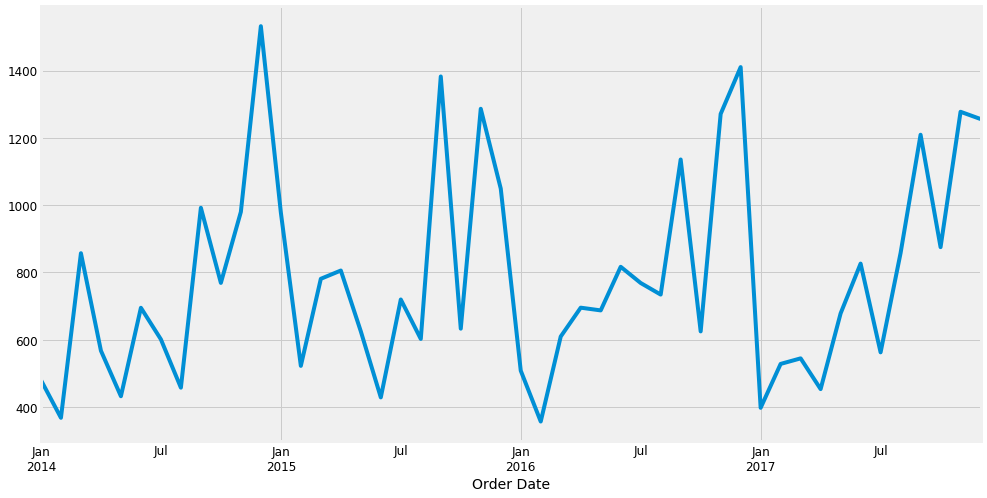

In [108]:
furniture_df_y.plot(figsize=(15, 8))

### Conclusion drawn from above Time Series 

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the end of the year. There is always an upward trend within any single year with a couple of low months in the mid of the year.

### Time Series Decomposition 

We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

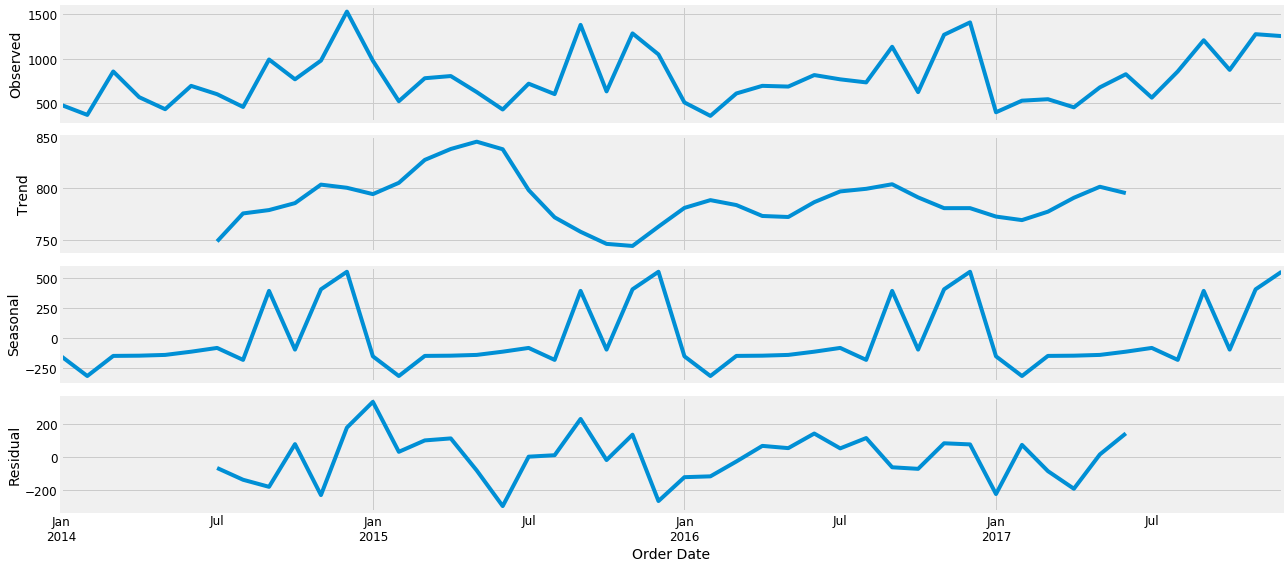

In [109]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(furniture_df_y, model='additive')

fig = decomposition.plot()

plt.show()

### Time series forecasting with ARIMA

We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.

ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:

Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.

It adds three new hyperparameters to specify the 
    
    autoregression (AR), 
    
    differencing (I), 
    
    and moving average (MA) for the seasonal component of the series, 
    
    as well as an additional parameter for the period of the seasonality.

Configuring a SARIMA requires selecting hyperparameters for both the trend and seasonal elements of the series.
There are three trend elements that require configuration.

They are the same as the ARIMA model; specifically:
p: Trend autoregression order.
d: Trend difference order.
q: Trend moving average order.

There are four seasonal elements that are not part of ARIMA that must be configured; they are:
P: Seasonal autoregressive order.
D: Seasonal difference order.
Q: Seasonal moving average order.
m: The number of time steps for a single seasonal period.


Together, the notation for a SARIMA model is specified as:

SARIMA(p,d,q)(P,D,Q)m

In [30]:
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [110]:
p = d = q = range(0, 2)

pdq = list(itertools.product(p, d, q))

pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [111]:
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

This step is parameter Selection for our furniture’s sales ARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.

if ARMA models (models in which contain both autoregressive components and moving average components) can be written as AR models, we say that the time series model is invertible. 

In [112]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            TS_model = sm.tsa.statespace.SARIMAX(furniture_df_y,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = TS_model.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:769.0817523205916
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1446.5593227130305
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:477.7170130920218
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:497.23144334183365
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1172.208674145885
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:318.0047199116341
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:720.9252270758095
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2900.357535652858
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:466.56074298091255
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:499.574045803366
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2513.1394870316744
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:319.98848769468657
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:677.894766843944
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1250.2320272227237
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:486.63785672282035
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:497.78896630044073
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1550.2003231687213
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:319.7714068109211
ARI


The above output suggests that SARIMAX(1, 1, 1)x(1, 1, 0, 12) yields the lowest AIC value of 297.78. Therefore we should consider this to be optimal option.


### What is AIC 

The Akaike Information Critera (AIC) is a widely used measure of a statistical model. It basically quantifies 1) the goodness of fit, and 2) the simplicity/parsimony, of the model into a single statistic.
When comparing two models, the one with the lower AIC is generally “better”. 

### Fitting the ARIMA model

In [113]:
TS_model = sm.tsa.statespace.SARIMAX(furniture_df_y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = TS_model.fit()

### Validating forecasts

To help us understand the accuracy of our forecasts, we compare predicted sales to real sales of the time series, and we set forecasts to start at 2017–01–01 to the end of the data.

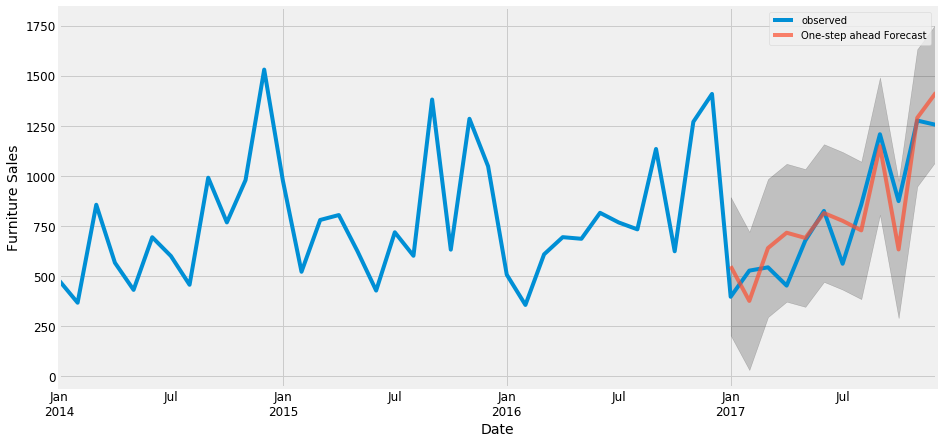

In [114]:
TS_pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)

pred_ci = TS_pred.conf_int()

ax = furniture_df_y['2014':].plot(label='observed')

TS_pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')

plt.legend()
plt.show()

### Producing and visualizing forecasts

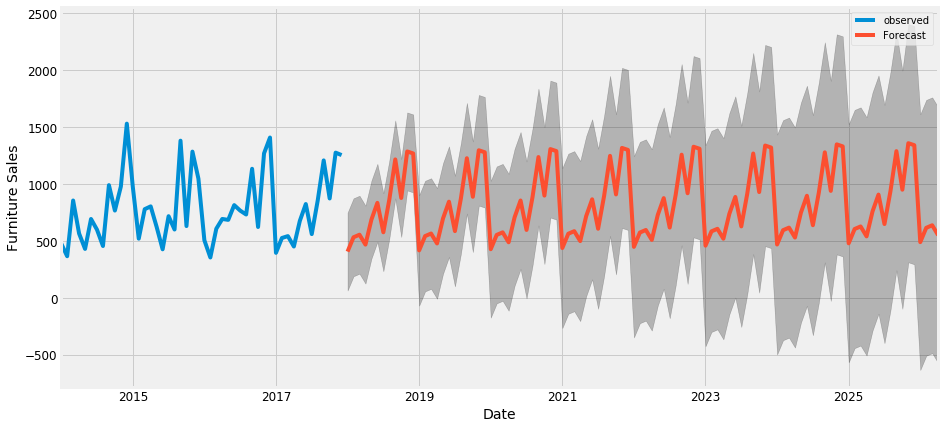

In [115]:
pred_uc = results.get_forecast(steps=100)

pred_ci = pred_uc.conf_int()

ax = furniture_df_y.plot(label='observed', figsize=(14, 7))

pred_uc.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')

ax.set_ylabel('Furniture Sales')

plt.legend()
plt.show()

Happy Learning !!


Thank You 